In [31]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [32]:
# !cp '/content/drive/MyDrive/spectrograms.zip' .

In [33]:
# !unzip -q spectrograms.zip

In [34]:
# !pip list

In [35]:
# !rm -r /content/logs

In [36]:
import keras.callbacks
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import math
import pandas as pd
import random
from tensorflow.keras import models, layers, callbacks, activations

import librosa
import librosa.display

import warnings

import pickle

AUTOTUNE = tf.data.AUTOTUNE

# tf.config.run_functions_eagerly(True)

In [37]:
RUN = '1'

SAMPLE_RATE = 24000
FREQ_SIZE = 188
SECONDS = 4

N_MFCC = 100

BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1
BATCH_SIZE_VAL = 50
EPOCHS = 75

NUM_TRAIN = 4500
NUM_VAL = 500
NUM_TEST = 250

STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE_TRAIN

NUM_LANGUAGES = 1
LANGUAGES = ['EN']

LOG_DIR = "logs/model" + str(NUM_LANGUAGES) + "-"

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)

LEARNING_RATE = 0.0001

In [38]:
BASE_DIR_EN = '../../../spectrograms/en/clips/'
TRAIN_PATH_EN = '../../../spectrograms/en/trainleft.tsv'
TEST_PATH_EN = '../../../spectrograms/en/testleft.tsv'
VAL_PATH_EN = '../../../spectrograms/en/valleft.tsv'

NUM_TRAIN_EN = NUM_TRAIN
NUM_VAL_EN = NUM_VAL
NUM_TEST_EN = NUM_TEST

LABELS_EN = ['zero','one','two','three','four','five','six','seven','eight','nine','ten','Hey','yes','no','Firefox']
NUM_LABELS_EN = len(LABELS_EN)

In [39]:
def padaudio(waveform):
    if (len(waveform) >= SAMPLE_RATE * SECONDS):
        return waveform
    else:
        return np.pad(waveform,(0,SAMPLE_RATE * SECONDS - len(waveform)),mode='constant', constant_values=(0,0))

# def processdata(file):
#     waveform,sample_rate = librosa.load(file, SAMPLE_RATE)
#     waveform = padaudio(waveform)
#     mfccs = librosa.feature.mfcc(waveform,sr=sample_rate,n_mfcc=N_MFCC)
#     mfccs = np.moveaxis(mfccs,1,0)
#     scaler = StandardScaler()
#     mfccs_scaled = scaler.fit_transform(mfccs)
#     return mfccs_scaled.reshape(mfccs_scaled.shape[0], mfccs_scaled.shape[1],1)

def processdata(file):
    # print(file)
    filename = '../../..' + file.split(".")[-2] + '.pkl'
    # print(filename)
    with open(filename,'rb') as f:
        spectrogram = pickle.load(f)
    return spectrogram

In [40]:
def getlabel(onehot,labels):
    index = np.argmax(onehot)
    label = labels[index]
    return label

def getonehot(label,labels):
    onehot = np.array([1 if x == label else 0 for x in labels])
    return onehot

In [41]:
def getdata(df,base_dir):
    df['fullpath'] = base_dir + df['path']
    inputs = df['fullpath'].tolist()
    labels = df['sentence'].tolist()
    x = np.array(inputs)
    y = np.array(labels)
    return x,y

In [42]:
dftrainEN = pd.read_csv(TRAIN_PATH_EN, sep='\t', header=0)
dftrainEN.sort_values(by='length',ascending=False,inplace=True)
trainxEN,trainyEN, = getdata(dftrainEN.head(NUM_TRAIN_EN), BASE_DIR_EN)

dfvalEN = pd.read_csv(VAL_PATH_EN, sep='\t', header=0)
dfvalEN.sort_values(by='length',ascending=False,inplace=True)
valxEN,valyEN, = getdata(dfvalEN.head(NUM_VAL_EN), BASE_DIR_EN)

dftestEN = pd.read_csv(TEST_PATH_EN, sep='\t', header=0)
dftestEN.sort_values(by='length',ascending=False,inplace=True)
testxEN,testyEN, = getdata(dftestEN.head(NUM_TEST_EN), BASE_DIR_EN)

C:\Users\aning\AppData\Local\Temp/ipykernel_23524/954889505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fullpath'] = base_dir + df['path']


In [44]:
def maketraingenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(trainxEN)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator


xtypes = tuple([tf.float32]*NUM_LANGUAGES)
ytypes = tuple([tf.int32]*NUM_LANGUAGES)
traingentypes = (xtypes,ytypes)

xshapes = tuple([[FREQ_SIZE,N_MFCC,1] for i in range(NUM_LANGUAGES)])
yshapes = tuple([[15]])
traingenshapes = (xshapes,yshapes)

In [45]:
def makevalgenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(valxEN)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator

In [46]:
trainxs = [trainxEN]
trainys = [[trainyEN,LABELS_EN]]

valxs = [valxEN]
valys = [[valyEN,LABELS_EN]]

In [48]:
def maketestgenerator(testx,testy,labels):
    def testgenerator():
        for i in range(len(testx)):
            x = processdata(testx[i])
            y = getonehot(testy[i],labels)
            yield x,y
    return testgenerator

testgentypes = (tf.float32,tf.int32)
testgenshapes = ([FREQ_SIZE,N_MFCC,1],[15])

In [49]:
traindataset = tf.data.Dataset.from_generator(maketraingenerator(trainxs,trainys),output_types=traingentypes,output_shapes=traingenshapes)
traindataset = traindataset.shuffle(NUM_TRAIN_EN)
traindataset = traindataset.batch(BATCH_SIZE_TRAIN)
traindataset = traindataset.repeat(-1)
traindataset = traindataset.cache().prefetch(AUTOTUNE)

valdataset = tf.data.Dataset.from_generator(makevalgenerator(valxs,valys),output_types=traingentypes,output_shapes=traingenshapes)
valdataset = valdataset.batch(BATCH_SIZE_VAL)
valdataset = valdataset.cache().prefetch(AUTOTUNE)

testdatasetEN = tf.data.Dataset.from_generator(maketestgenerator(testxEN,testyEN,LABELS_EN),output_types=testgentypes,output_shapes=testgenshapes)
testdatasetEN = testdatasetEN.batch(BATCH_SIZE_TEST)

In [52]:
def languagelayers(num_labels,language):
        lang = keras.Sequential([
        layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name=language+'_Conv2D1'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D1'),
        # layers.Conv2D(filters=512, kernel_size=(2,2), strides=(1,1), padding='same', activation=activations.relu, name=language+'_Conv2D2'),
        # layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D2'),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer1'),
        layers.Dropout(0.5),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer2'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation=activations.softmax, name=language+'_Output')
        ],
        name=language)

        return lang

Model: "Full_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EN_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                                 

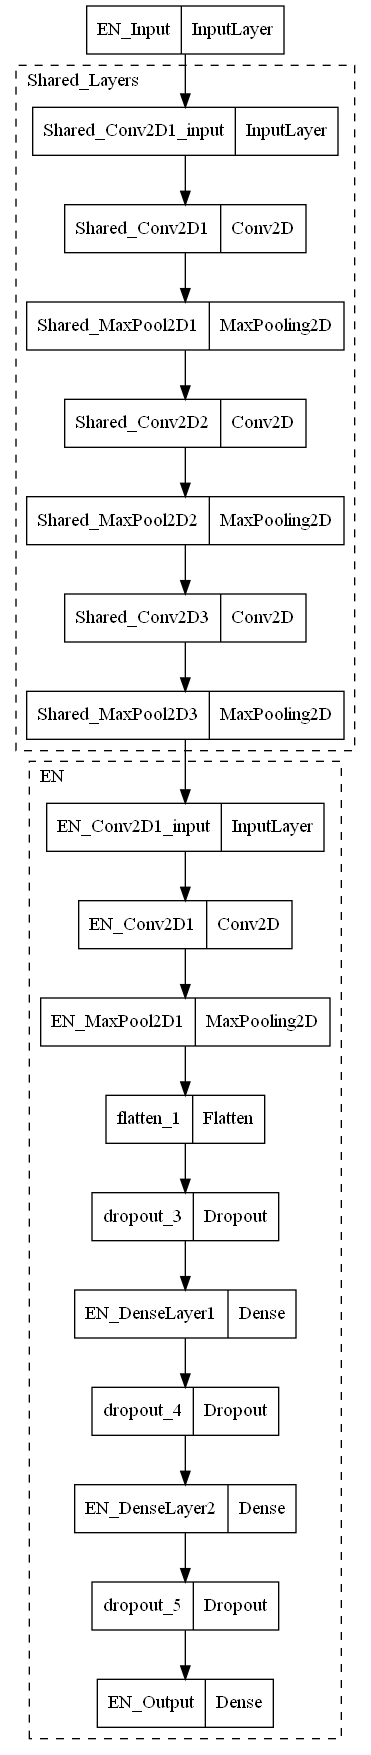

In [53]:
inputEN = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='EN_Input')

shared = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(9,9), strides=(2,2), padding='same', activation=activations.relu, name='Shared_Conv2D1'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D1'),
    layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D2'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D2'),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D3'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D3'),
    # layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D4'),
    # layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name='Shared_MaxPool2D4'),
    ],
    name='Shared_Layers'
)

sharedLayersEN = shared(inputEN)

layersEN = languagelayers(NUM_LABELS_EN,'EN')(sharedLayersEN)


model = tf.keras.Model(
    inputs=[inputEN],
    outputs=[layersEN],
    name='Full_Model'
)


model.summary(expand_nested=True)
tf.keras.utils.plot_model(model, expand_nested=True)

In [54]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [55]:
training_callback = callbacks.TensorBoard(log_dir=LOG_DIR + RUN)
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [57]:
history = model.fit(
    x = traindataset,
    validation_data = valdataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callback,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
45/45 [==============================] - 55s 625ms/step - loss: 2.7273 - Categorical_Accuracy: 0.0724 - AUC: 0.5072 - val_loss: 2.6951 - val_Categorical_Accuracy: 0.0920 - val_AUC: 0.5675 - lr: 1.0000e-04

ResourceExhaustedError:  OOM when allocating tensor with shape[100,94,50,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node gradient_tape/Full_Model/Shared_Layers/Shared_MaxPool2D1/MaxPool/MaxPoolGrad
 (defined at C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:464)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5288]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/Full_Model/Shared_Layers/Shared_MaxPool2D1/MaxPool/MaxPoolGrad:
In[0] Full_Model/Shared_Layers/Shared_Conv2D1/Relu (defined at C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\keras\backend.py:4867)	
In[1] Full_Model/Shared_Layers/Shared_MaxPool2D1/MaxPool (defined at C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\keras\layers\pooling.py:357)	
In[2] gradient_tape/Full_Model/Shared_Layers/Shared_Conv2D2/Conv2D/Conv2DBackpropInput:

Operation defined at: (most recent call last)
>>>   File "C:\Python39\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Python39\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Python39\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Python39\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\aning\AppData\Local\Temp/ipykernel_23524/669891061.py", line 1, in <module>
>>>     history = model.fit(
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\keras\engine\training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 530, in minimize
>>>     grads_and_vars = self._compute_gradients(
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 583, in _compute_gradients
>>>     grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
>>> 
>>>   File "C:\Users\aning\Desktop\Class 6\Brain AI\Project\Code\brainai\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 464, in _get_gradients
>>>     grads = tape.gradient(loss, var_list, grad_loss)
>>> 

In [ ]:
model.evaluate(testdatasetEN)

In [ ]:
# model.save('savedmodels/model27')
# shared.save('savedmodels/model27-Shared')

In [ ]:
# modelsave = keras.models.load_model('savedmodels/model22')